In [1]:
import paddle
import paddle.nn as nn
import paddle.optimizer as optim
import numpy as np
import os
from PIL import Image
from paddle.io import Dataset, DataLoader
from numpy.core.defchararray import decode, mod
import paddle
import numpy as np
import paddle.fluid as fluid
from paddle.fluid.dygraph import to_variable
from paddle.fluid.dygraph import Layer
from paddle.fluid.dygraph import Conv2D
from paddle.fluid.dygraph import BatchNorm
from paddle.fluid.dygraph import Pool2D
from paddle.fluid.dygraph import Conv2DTranspose
from visualdl import LogWriter
from datetime import datetime

PLEASE USE OMP_NUM_THREADS WISELY.


In [2]:
class Encoder(Layer):
    def __init__(self, num_channels, num_filters):
        super(Encoder, self).__init__()
        # TODO：encoder contains:
        # 3×3 conv + bn + relu
        # 3×3 conv + bn + relu
        # 2×2 pool
        # return features before and after pool  
        self.conv1 = Conv2D(num_channels=num_channels,
                            num_filters=num_filters,
                            filter_size=3,
                            stride=1,
                            padding=1)  # 3×3卷积的时候，padding=1的时候，尺寸不会变
        self.bn1 = BatchNorm(num_filters, act='relu')

        self.conv2 = Conv2D(num_channels=num_filters,
                            num_filters=num_filters,
                            filter_size=3,
                            stride=1,
                            padding=1)
        self.bn2 = BatchNorm(num_filters, act='relu')

        self.pool = Pool2D(pool_size=2, pool_stride=2, pool_type='max', ceil_mode=True)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x) # 灰色箭头concat
        x_pooled = self.pool(x)
        
        return x, x_pooled


class Decoder(Layer):
    def __init__(self, num_channels, num_filters):
        super(Decoder, self).__init__()
        # TODO：encoder contains:
        # 2×2 transpose conv, stride=2, p=0 (makes feature map 2× larger)
        # 3×3 conv + bn + relu
        # 3×3 conv + bn + relu
        self.up = Conv2DTranspose(num_channels=num_channels,    # 1024->512
                                  num_filters=num_filters,
                                  filter_size=2,
                                  stride=2)
        
        self.conv1 = Conv2D(num_channels=num_channels,  # 1024
                            num_filters=num_filters,
                            filter_size=3,
                            stride=1,
                            padding=1)

        self.bn1 = BatchNorm(num_channels=num_filters, act='relu')

        self.conv2 = Conv2D(num_channels=num_filters,
                            num_filters=num_filters,
                            filter_size=3,
                            stride=1,
                            padding=1)

        self.bn2 = BatchNorm(num_channels=num_filters, act='relu')
    
    def forward(self, inputs_prev, inputs):
        # TODO:forward contains an pad2d and concat
        # 原论文是input_prev进行crop，这里是对x进行padding，目的一样，就是把保证HW一致，进行concat
        x = self.up(inputs)
        # NCHW
        h_diff = (inputs_prev.shape[2] - x.shape[2])
        w_diff = (inputs_prev.shape[3] - x.shape[3])
        x = fluid.layers.pad2d(x, paddings=[h_diff//2, h_diff - h_diff//2, w_diff//2, w_diff - w_diff//2])
        # axis=1为C。NCHW，把channel concat
        x = fluid.layers.concat([inputs_prev, x], axis=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x


class UNet(Layer):
    def __init__(self, num_classes=59):
        super(UNet, self).__init__()
        # encoder: 3->64->128->256->512
        # mid: 512->1024->1024

        # TODO: 4 encoders, 4 decoders, and mid layers contain 2x (1x1conv+bn+relu)
        self.down1 = Encoder(num_channels=3, num_filters=64)
        self.down2 = Encoder(num_channels=64, num_filters=128)
        self.down3 = Encoder(num_channels=128, num_filters=256)
        self.down4 = Encoder(num_channels=256, num_filters=512)

        # 原论文应该是 3x3 padding=1,stride=1,这里使用1x1卷积
        self.midconv1 = Conv2D(num_channels=512, num_filters=1024, filter_size=1, padding =0, stride=1)
        self.bn1 = BatchNorm(num_channels=1024, act='relu')
        self.midconv2 = Conv2D(num_channels=1024, num_filters=1024, filter_size=1, padding=0, stride=1)
        self.bn2 = BatchNorm(num_channels=1024, act='relu')

        self.up1 = Decoder(num_channels=1024, num_filters=512)
        self.up2 = Decoder(num_channels=512, num_filters=256)
        self.up3 = Decoder(num_channels=256, num_filters=128)
        self.up4 = Decoder(num_channels=128, num_filters=64)

        # last_conv： channel：64->num_classes
        self.last_conv = Conv2D(num_channels=64, num_filters=num_classes, filter_size=1)


    def forward(self, inputs):
        # encoder layer
        #print('encoder layer:')
        x1, x = self.down1(inputs)
        #print('input_pred:',x1.shape, 'x_pooled：', x.shape)
        x2, x = self.down2(x)
        #print('input_pred:',x2.shape, 'x_pooled：', x.shape)
        x3, x = self.down3(x)
        #print('input_pred:',x3.shape, 'x_pooled：', x.shape)
        x4, x = self.down4(x)
        #print('input_pred:',x4.shape, 'x_pooled：', x.shape)

        # middle layer
        x = self.midconv1(x)
        x = self.bn1(x)
        x = self.midconv2(x)
        x = self.bn2(x)

        # decoder layer
        #print('decoder layer:')
        x = self.up1(x4, x)
        #print('up1_input_pred:',x4.shape, 'up1：', x.shape)
        x = self.up2(x3, x)
        #print('up2_input_pred:',x3.shape, 'up2：', x.shape)
        x = self.up3(x2, x)
        #print('up3_input_pred:',x2.shape, 'up3：', x.shape)
        x = self.up4(x1, x)
        #print('up4_input_pred:',x1.shape, 'up4：', x.shape)

        x = self.last_conv(x)
        #print('out_put:', x.shape)

        return x


In [3]:
# 1. 数据加载
class EyeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_size = transform_size
        self.image_list = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, os.path.splitext(self.image_list[idx])[0] + '.bmp')
        
        # 使用resize方法调整图像和掩码的尺寸
        image = Image.open(image_path).convert('RGB').resize(self.transform_size)
        mask = Image.open(mask_path).convert('L').resize(self.transform_size)
        
        image = paddle.to_tensor(np.array(image).astype('float32').transpose((2, 0, 1)) / 255.0)
        mask = paddle.to_tensor(np.array(mask).astype('float32')[np.newaxis, :, :] / 255.0)
        
        return image, mask
    
    def __len__(self):
        return len(self.image_list)

data_dir = "data/Train"
fundus_image_dir = os.path.join(data_dir, "fundus_image")
completed_masks_dir = os.path.join(data_dir, "Lesion_Masks", "Completed_Masks", "Atrophy")  # 使用Atrophy作为示例

train_dataset = EyeDataset(fundus_image_dir, completed_masks_dir, transform_size=(512,512))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [4]:
import time  # 导入time模块

epochs = 50

# 创建一个LogWriter对象
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = f"unet_vdl_logs/{current_time}_epochs_{epochs}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = LogWriter(log_dir)

# 3. 模型训练
model = UNet(num_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(parameters=model.parameters(), learning_rate=0.001)

for epoch in range(epochs):
    total_loss = 0.0
    start_time = time.time()  # 记录epoch开始时间
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        
        total_loss += loss.numpy()[0]
        print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.numpy()[0]}")
        
    # 记录平均loss到VisualDL
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar(tag="train/avg_loss", step=epoch, value=avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

    # 每个epoch结束后保存模型
    model_path = os.path.join("Unet_models", f"unet_epoch{epoch+1}.pdparams")
    paddle.save(model.state_dict(), model_path)
    print(f"Saved model parameters to {model_path}")

    end_time = time.time()  # 记录epoch结束时间
    elapsed_time = end_time - start_time  # 计算epoch的训练时间
    print(f"Epoch {epoch+1} training time: {elapsed_time:.2f} seconds")

print("Training completed!")


W0813 14:46:12.950276   815 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.0, Runtime API Version: 11.2
W0813 14:46:12.954282   815 device_context.cc:465] device: 0, cuDNN Version: 8.1.


Epoch 1/50, Batch 1/100, Loss: 0.8464601039886475
Epoch 1/50, Batch 2/100, Loss: 0.7884594202041626
Epoch 1/50, Batch 3/100, Loss: 0.5653164386749268
Epoch 1/50, Batch 4/100, Loss: 0.44434690475463867
Epoch 1/50, Batch 5/100, Loss: 0.3931688964366913
Epoch 1/50, Batch 6/100, Loss: 0.3720991909503937
Epoch 1/50, Batch 7/100, Loss: 0.33289018273353577
Epoch 1/50, Batch 8/100, Loss: 0.32711198925971985
Epoch 1/50, Batch 9/100, Loss: 0.3097726106643677
Epoch 1/50, Batch 10/100, Loss: 0.28116437792778015
Epoch 1/50, Batch 11/100, Loss: 0.217435821890831
Epoch 1/50, Batch 12/100, Loss: 0.3669527769088745
Epoch 1/50, Batch 13/100, Loss: 0.21827994287014008
Epoch 1/50, Batch 14/100, Loss: 0.2626889646053314
Epoch 1/50, Batch 15/100, Loss: 0.2929624617099762
Epoch 1/50, Batch 16/100, Loss: 0.2765800356864929
Epoch 1/50, Batch 17/100, Loss: 0.22495310008525848
Epoch 1/50, Batch 18/100, Loss: 0.317893922328949
Epoch 1/50, Batch 19/100, Loss: 0.16910454630851746
Epoch 1/50, Batch 20/100, Loss: 0.2

In [9]:
from datetime import datetime
# 1. 初始化模型
model = UNet(num_classes=1)

# 2. 加载模型参数
start_epoch = 50
model_path = os.path.join("models", f"unet_epoch{start_epoch}.pdparams")
model_state_dict = paddle.load(model_path)
model.set_state_dict(model_state_dict)
print(f"Loaded model parameters from {model_path}")

# 3. 设置损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(parameters=model.parameters(), learning_rate=0.001)

# 创建一个LogWriter对象
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = f"vdl_logs/{current_time}_epochs_{epochs}_from_epoch_{start_epoch}"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = LogWriter(log_dir)

# 4. 继续训练
epochs = 60
for epoch in range(start_epoch, epochs):
    total_loss = 0.0
    for batch_idx, (images, masks) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        total_loss += loss.numpy()[0]
        print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.numpy()[0]}")

    # 记录平均loss到VisualDL
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar(tag="train/avg_loss", step=epoch, value=avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

    # 挑选一个测试图片放入VDL
    test_image, test_mask = next(iter(test_loader))
    test_output = model(test_image)
    writer.add_image(tag="test/image", img=test_image[0], step=epoch)
    writer.add_image(tag="test/prediction", img=test_output[0], step=epoch)
    writer.add_image(tag="test/mask", img=test_mask[0], step=epoch)

    # 每个epoch结束后保存模型
    model_path = os.path.join("Unet_models", f"unet_epoch{epoch+1}.pdparams")
    paddle.save(model.state_dict(), model_path)
    print(f"Saved model parameters to {model_path}")

print("Training completed!")


W0812 19:58:10.036633   816 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.0, Runtime API Version: 11.2
W0812 19:58:10.040460   816 device_context.cc:465] device: 0, cuDNN Version: 8.1.


Loaded model parameters from models/unet_epoch50.pdparams
Epoch 51/60, Batch 1/100, Loss: 0.06657276302576065
Epoch 51/60, Batch 2/100, Loss: 0.0694594755768776
Epoch 51/60, Batch 3/100, Loss: 0.15546706318855286
Epoch 51/60, Batch 4/100, Loss: 0.07975435256958008
Epoch 51/60, Batch 5/100, Loss: 0.07151706516742706
Epoch 51/60, Batch 6/100, Loss: 0.08240658789873123
Epoch 51/60, Batch 7/100, Loss: 0.04608643054962158
Epoch 51/60, Batch 8/100, Loss: 0.06681846082210541
Epoch 51/60, Batch 9/100, Loss: 0.04484133422374725
Epoch 51/60, Batch 10/100, Loss: 0.15420924127101898
Epoch 51/60, Batch 11/100, Loss: 0.09321074187755585
Epoch 51/60, Batch 12/100, Loss: 0.04096284508705139
Epoch 51/60, Batch 13/100, Loss: 0.05036269873380661
Epoch 51/60, Batch 14/100, Loss: 0.06247153505682945
Epoch 51/60, Batch 15/100, Loss: 0.06125855818390846
Epoch 51/60, Batch 16/100, Loss: 0.03740565478801727
Epoch 51/60, Batch 17/100, Loss: 0.06555814296007156
Epoch 51/60, Batch 18/100, Loss: 0.0509505905210971

In [ ]:
def evaluate(model, criterion, dataloader):
    model.eval()  # 设置模型为评估模式
    total_loss = 0.0
    with paddle.no_grad():
        for images, masks in dataloader:
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.numpy()[0]
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def test(model, dataloader, save_dir="predictions"):
    model.eval()  # 设置模型为评估模式
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with paddle.no_grad():
        for idx, (images, _) in enumerate(dataloader):
            outputs = model(images)
            # 将输出转换为二值掩码
            predicted_masks = (outputs > 0.5).astype('float32')
            for i, mask in enumerate(predicted_masks):
                mask_img = Image.fromarray((mask[0].numpy() * 255).astype(np.uint8))
                mask_img.save(os.path.join(save_dir, f"predicted_mask_{idx * len(images) + i}.bmp"))

# 加载模型参数
model_path = "path_to_your_saved_model.pdparams"
model_state_dict = paddle.load(model_path)
model.set_state_dict(model_state_dict)

# 创建验证集和测试集的DataLoader
val_dataset = EyeDataset(val_image_dir, val_mask_dir, transform_size=(512,512))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

test_dataset = EyeDataset(test_image_dir, test_mask_dir, transform_size=(512,512))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# 评估模型
val_loss = evaluate(model, criterion, val_loader)
print(f"Validation Loss: {val_loss}")

# 测试模型
test(model, test_loader)
print("Testing completed and predictions saved!")


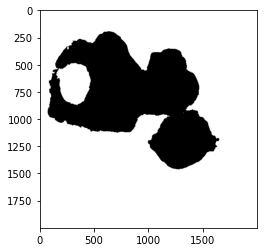

In [6]:
# 测试单张
import matplotlib.pyplot as plt


def predict_single_image(model, image_path, transform_size=(512, 512)):
    # 加载和预处理图像
    image = Image.open(image_path).convert('RGB').resize(transform_size)
    image_tensor = paddle.to_tensor(np.array(image).astype('float32').transpose((2, 0, 1)) / 255.0)
    image_tensor = paddle.unsqueeze(image_tensor, 0)  # 添加batch维度

    # 使用模型进行预测
    model.eval()
    with paddle.no_grad():
        output = model(image_tensor)
        predicted_mask = (output > 0.5).astype('float32')

    # 将预测的掩码转换回图像格式
    mask_img = Image.fromarray((predicted_mask[0][0].numpy() * 255).astype(np.uint8)).resize((2000, 2000))
    
    return mask_img
model = UNet(num_classes=1)
# 加载模型参数
model_path = "Unet_models/unet_epoch50.pdparams"
model_state_dict = paddle.load(model_path)
model.set_state_dict(model_state_dict)

# 预测单张图像
image_path = "V0017.jpg"
predicted_mask_img = predict_single_image(model, image_path)

# 展示预测的掩码
plt.imshow(predicted_mask_img, cmap='gray')
plt.show()

# 保存预测的掩码
predicted_mask_img.save("V0017.bmp")
